### Predict 2 meter temperature with sea surface temperature using deep learning and evaluate the predictions with linear regression results

![forecast](../assets/concept_example_data.png)

In [1]:
import lilio
import numpy as np
import sys
import time as tt
import wandb
import xarray as xr
from pathlib import Path
from s2spy import preprocess
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

sys.path.append("../src/")
from transformer import Transformer
import utils

# for reproducibility 
np.random.seed(0)
torch.manual_seed(0)

#### 1. Prepare data for data-driven forecasting with `s2spy` & `lilio`

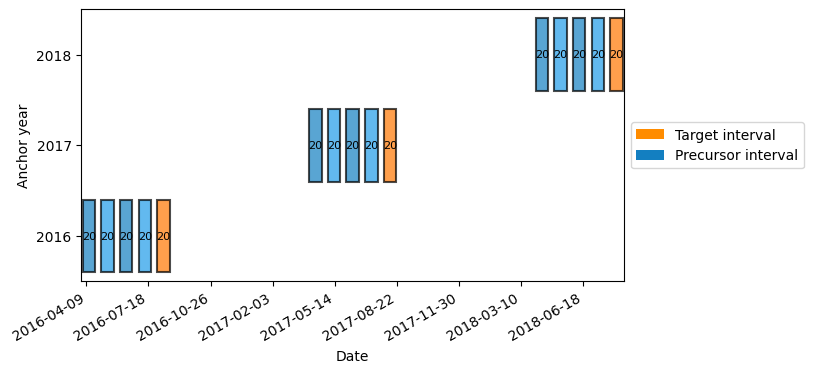

In [2]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="20d")
# add precursor periods
periods_of_interest = 4
calendar.add_intervals("precursor", "20d", gap="10d", n=periods_of_interest)

# load example data
data_folder = '~/AI4S2S/data'
precursor_field = xr.open_dataset(Path(data_folder, 'sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc'))
target_field = xr.open_dataset(Path(data_folder,'tf5_nc5_dendo_80d77.nc'))

# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

##### Train-validate-test split based on the anchor years (70%/15%/15% split)

In [3]:
# get 70% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.7)
test_samples = round(len(years) * 0.15)
start_year = years[0]

# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(precursor_field.sel(time=slice(str(start_year),
                                                str(start_year + train_samples - 1))))

# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['ts'].sel(cluster=3)

#### 2. Train a deep neural network for forecasting


In [4]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_sel.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_sel.latitude)
lon_precursor = len(precursor_field_sel.longitude)

X_torch = torch.from_numpy(precursor_field_sel[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_series_sel[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)
y_torch = y_torch.unsqueeze(1).unsqueeze(1).repeat(1, 1, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

In [5]:
# call weights & biases service
wandb.login()

hyperparameters = dict(
    epoch = 100,
    num_encoder_layers = 1,
    num_decoder_layers = 1,
    dim_model = lat_precursor*lon_precursor,
    num_heads = 2,
    dim_feedforward = 12,
    batch_size = 4,
    dropout = 0.1,
    learning_rate = 0.01,
    periods_of_interest = periods_of_interest,
    dataset = 'Weather',
    architecture = 'Transformer'
)

# initialize weights & biases service
#mode = 'online'
mode = 'disabled'
wandb.init(config=hyperparameters, project='demo', entity='ai4s2s', mode=mode)
config = wandb.config

# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: git-yang (ai4s2s). Use `wandb login --relogin` to force relogin


![architecture](../assets/transformer.webp)

In [6]:
# Initialize model
model = Transformer(num_encoder_layers = config["num_encoder_layers"],
                    num_decoder_layers = config["num_decoder_layers"],
                    dim_model = config["dim_model"], 
                    num_heads = config["num_heads"], 
                    dim_feedforward = config["dim_feedforward"], 
                    dropout = config["dropout"])
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): Residual(
          (sublayer): MultiHeadAttention(
            (heads): ModuleList(
              (0-1): 2 x AttentionHead(
                (q): Linear(in_features=65, out_features=32, bias=True)
                (k): Linear(in_features=65, out_features=32, bias=True)
                (v): Linear(in_features=65, out_features=32, bias=True)
              )
            )
            (linear): Linear(in_features=64, out_features=65, bias=True)
          )
          (norm): LayerNorm((65,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): Residual(
          (sublayer): Sequential(
            (0): Linear(in_features=65, out_features=12, bias=True)
            (1): ReLU()
            (2): Linear(in_features=12, out_features=65, bias=True)
          )
          (norm): LayerNorm

[]

In [7]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = torch.autograd.Variable(X_batch)
        var_y_batch = torch.autograd.Variable(y_batch)
        optimizer.zero_grad()
        # note: decoder input is the last instance of encoder input
        output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        if batch_idx % 2 == 0:
            print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
                  f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = torch.autograd.Variable(X_batch)
        var_y_batch = torch.autograd.Variable(y_batch)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
            loss = criterion(output, var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

fig = plt.figure()
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch : 0 [0/28(0%)]	Loss: 2.397214
Epoch : 0 [8/28(29%)]	Loss: 4.731446
Epoch : 0 [16/28(57%)]	Loss: 2.491815
Epoch : 0 [24/28(86%)]	Loss: 3.442825
Epoch : 1 [0/28(0%)]	Loss: 2.688605
Epoch : 1 [8/28(29%)]	Loss: 2.814894
Epoch : 1 [16/28(57%)]	Loss: 0.918126
Epoch : 1 [24/28(86%)]	Loss: 4.211689
Epoch : 2 [0/28(0%)]	Loss: 1.842609
Epoch : 2 [8/28(29%)]	Loss: 1.320726
Epoch : 2 [16/28(57%)]	Loss: 1.093432
Epoch : 2 [24/28(86%)]	Loss: 3.495211
Epoch : 3 [0/28(0%)]	Loss: 0.430424
Epoch : 3 [8/28(29%)]	Loss: 1.570527
Epoch : 3 [16/28(57%)]	Loss: 1.253365
Epoch : 3 [24/28(86%)]	Loss: 2.009565
Epoch : 4 [0/28(0%)]	Loss: 1.522647
Epoch : 4 [8/28(29%)]	Loss: 1.127396
Epoch : 4 [16/28(57%)]	Loss: 2.652472
Epoch : 4 [24/28(86%)]	Loss: 0.830875
Epoch : 5 [0/28(0%)]	Loss: 1.081327
Epoch : 5 [8/28(29%)]	Loss: 1.432137
Epoch : 5 [16/28(57%)]	Loss: 3.095004
Epoch : 5 [24/28(86%)]	Loss: 1.738760
Epoch : 6 [0/28(0%)]	Loss: 0.284843
Epoch : 6 [8/28(29%)]	Loss: 1.356855
Epoch : 6 [16/28(57%)]	Loss: 0.33

In [9]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = torch.autograd.Variable(X_batch)
    var_y_batch = torch.autograd.Variable(y_batch)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
        loss = criterion(output, var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(torch.mean(output.squeeze(), dim=1).cpu().detach().numpy())
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

fig = plt.figure()
instances = np.arange(len(np.concatenate(predictions)))
plt.scatter(instances, np.concatenate(predictions), label="Predictions")
plt.scatter(instances, np.mean(test_y_torch.squeeze().numpy(), 1), label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()

#### 3. Evaluate predictions with baseline model

In [11]:
from s2spy import RGDR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

# cross-validation with Kfold
k_fold_splits = 5
kfold = KFold(n_splits=k_fold_splits)
cv = lilio.traintest.TrainTestSplit(kfold)

# create lists for saving models and predictions
models = []
RGDRs = []
rmse_train = []
rmse_test = []
train_test_splits = []

# prepare operator for dimensionality reduction
target_intervals = 1
lag = 2

# cross validation based dimensionality reduction and model training
for x_train, x_test, y_train, y_test in cv.split(precursor_field_sel[:-test_samples],
                                                 y=target_series_sel[:-test_samples]):
    # log train/test splits with anchor years
    train_test_splits.append({
        "train": x_train.anchor_year.values,
        "test": x_test.anchor_year.values,
    })
    # fit dimensionality reduction operator RGDR
    rgdr = RGDR(
        target_intervals=target_intervals,
        lag=lag,
        eps_km=600,
        alpha=0.05,
        min_area_km2=0
    )
    rgdr.fit(x_train, y_train)
    # save dimensionality reduction operator
    RGDRs.append(rgdr)
    # transform to train and test data
    clusters_train = rgdr.transform(x_train)
    clusters_test = rgdr.transform(x_test)
    # train model
    ridge = Ridge(alpha=1.0)
    model = ridge.fit(clusters_train.isel(i_interval=0), y_train.sel(i_interval=1))
    # save model
    models.append(model)
    # predict and save results
    prediction = model.predict(clusters_test.isel(i_interval=0))
    # calculate and save rmse
    rmse_train.append(mean_squared_error(y_train.sel(i_interval=1),
                                         model.predict(clusters_train.isel(i_interval=0))))
    rmse_test.append(mean_squared_error(y_test.sel(i_interval=1),
                                        prediction))

In [13]:
# dimensionality reduction with the RGDR operator used by the best model
clusters_test = RGDRs[np.argmax(rmse_test)].transform(precursor_field_sel[-test_samples:])
# predict with the best model
predictions_baseline = models[np.argmax(rmse_test)].predict(clusters_test.isel(i_interval=0))

Let's plot all predictions and the ground truth and check the errors.

The MSE of LSTM forecasts is 3.023
The MSE of baseline ridge forecasts is 3.198


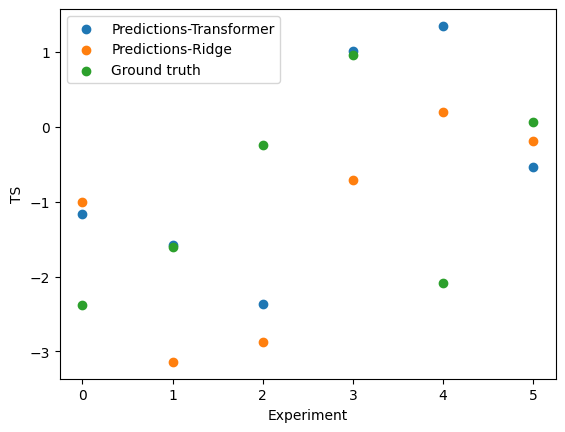

In [16]:
ground_truth = np.mean(test_y_torch.squeeze().numpy(), 1)

print(
    f"The MSE of LSTM forecasts is {mean_squared_error(ground_truth, np.concatenate(predictions)):.3f}"
)
print(
    f"The MSE of baseline ridge forecasts is {mean_squared_error(ground_truth, predictions_baseline):.3f}"
)

fig = plt.figure()
plt.scatter(instances, np.concatenate(predictions), label="Predictions-Transformer")
plt.scatter(instances, predictions_baseline, label="Predictions-Ridge")
plt.scatter(instances, ground_truth, label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()